# Testing Model over updated weights 

## Epochs = 3
## Accuracy = 97


In [1]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from safetensors.torch import load_file

# Define the path to the best checkpoint
checkpoint_path = "./bert-hate-speech2/checkpoint-20424"  # Update to actual best checkpoint path

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Load model architecture
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Load fine-tuned weights
weights_path = f"{checkpoint_path}/model.safetensors"
model.load_state_dict(load_file(weights_path))
model.eval()  # Set to evaluation mode


/home/atharva/anaconda3/envs/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to GPU
def predict_hate_speech(texts, batch_size=32):
    """Efficiently tokenize and predict labels in batches."""
    all_preds = []
    model.eval()  # Ensure model is in evaluation mode
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i : i + batch_size]
        
        # Tokenize the batch
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=128)
        inputs = {key: val.to(device) for key, val in inputs.items()}  # Move to GPU

        with torch.no_grad():
            outputs = model(**inputs)
        
        # Get predicted labels
        logits = outputs.logits
        batch_preds = torch.argmax(logits, dim=-1).cpu().tolist()  # Move to CPU for processing
        all_preds.extend(batch_preds)

    return all_preds

In [3]:
# Example sentences
samples = [
 " i ve seen afro americans who look and undoubtedly act like him",
"hyper text transfer protocol www occultopedia com f feral children http www long lands ac uk chimp la http www occultopedia com wild peter him aragon again every time i will see filthy comment about georgia without providing any facts i will respond",
"i will respond until armenian scum will stop",
"the reason large white families were encouraged those days what a slut to build up the population of white germans which were ravaged by the jewish attacks at them during and in hyperinflation",
"i see a nation where i can walk out my front door and not feel like a minority in my own country",
"where a white woman can go about in public and not fear assault by mud,"
"no i see that as giving up",
"i hope one day to proudly say again that i am an american when whatever take this country back",
"okay i have been through some other threads on this section about nice and watched a few videos on you there",
"it has obviously been misunderstood and i would have been keen to learn more",
"i retract always because an animal lacks the skills to properly raise a half human child",
"i apologize for my ignorance"
]

# Run predictions
for text in samples:
    result = predict_hate_speech(text)
    print(f"Text: {text}\nPrediction: {result}\n")


Text:  i ve seen afro americans who look and undoubtedly act like him
Prediction: [1, 1]

Text: hyper text transfer protocol www occultopedia com f feral children http www long lands ac uk chimp la http www occultopedia com wild peter him aragon again every time i will see filthy comment about georgia without providing any facts i will respond
Prediction: [0, 0, 0, 0, 1, 1, 0, 0]

Text: i will respond until armenian scum will stop
Prediction: [0, 0]

Text: the reason large white families were encouraged those days what a slut to build up the population of white germans which were ravaged by the jewish attacks at them during and in hyperinflation
Prediction: [1, 1, 0, 1, 1, 0]

Text: i see a nation where i can walk out my front door and not feel like a minority in my own country
Prediction: [0, 0, 0]

Text: where a white woman can go about in public and not fear assault by mud,no i see that as giving up
Prediction: [1, 0, 1, 1]

Text: i hope one day to proudly say again that i am an ame

In [4]:
import pandas as pd
df = pd.read_csv("HateSpeechDatasetBalanced.csv")
val_texts = df["Content"].tolist()
val_labels = df["Label"].tolist()


Classification Report:
                  precision    recall  f1-score   support

Not Hate Speech       0.96      0.98      0.97    361594
    Hate Speech       0.98      0.96      0.97    364525

       accuracy                           0.97    726119
      macro avg       0.97      0.97      0.97    726119
   weighted avg       0.97      0.97      0.97    726119



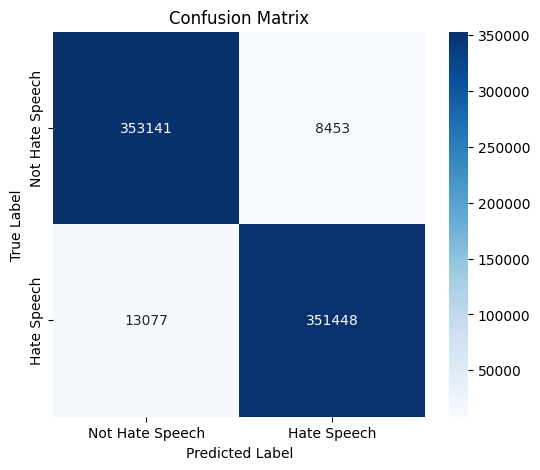

In [5]:
from sklearn.metrics import confusion_matrix, classification_report
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertForSequenceClassification
from safetensors.torch import load_file


predicted_labels = predict_hate_speech(val_texts)

# Generate confusion matrix
cm = confusion_matrix(val_labels, predicted_labels)

# Print classification report
print("Classification Report:\n", classification_report(val_labels, predicted_labels, target_names=["Not Hate Speech", "Hate Speech"]))

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Hate Speech", "Hate Speech"], yticklabels=["Not Hate Speech", "Hate Speech"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

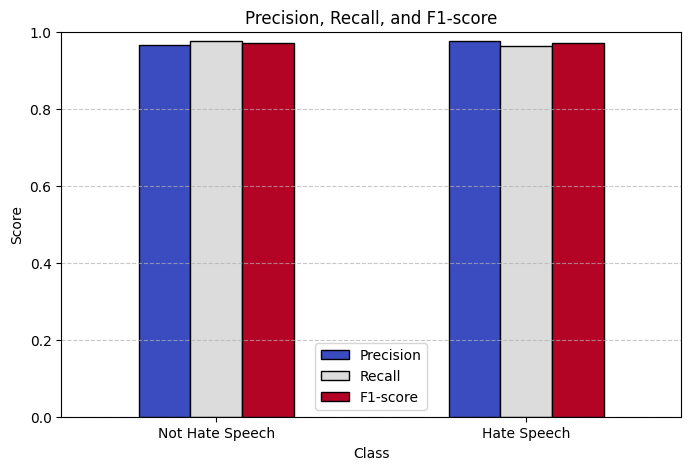

In [6]:
from sklearn.metrics import precision_recall_fscore_support

# Compute precision, recall, and f1-score
precision, recall, f1, _ = precision_recall_fscore_support(val_labels, predicted_labels, average=None)

# Create DataFrame for visualization
metrics_df = pd.DataFrame({
    "Class": ["Not Hate Speech", "Hate Speech"],
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1
})

# Plot
metrics_df.set_index("Class").plot(kind="bar", figsize=(8, 5), colormap="coolwarm", edgecolor="black")
plt.title("Precision, Recall, and F1-score")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [7]:
import torch

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to GPU

def predict_hate_speech(texts, batch_size=32):
    """Efficiently tokenize and predict labels in batches."""
    all_preds = []
    model.eval()  # Ensure model is in evaluation mode

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i : i + batch_size]

        # Tokenize the batch
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=128)
        inputs = {key: val.to(device) for key, val in inputs.items()}  # Move to GPU

        with torch.no_grad():
            outputs = model(**inputs)

        # Get predicted labels (0 = Not Hate Speech, 1 = Hate Speech)
        logits = outputs.logits
        batch_preds = torch.argmax(logits, dim=-1).cpu().tolist()  # Move to CPU
        all_preds.extend(batch_preds)

    return all_preds

# Example sentences
samples = [
 " i ve seen afro americans who look and undoubtedly act like him",
"hyper text transfer protocol www occultopedia com f feral children http www long lands ac uk chimp la http www occultopedia com wild peter him aragon again every time i will see filthy comment about georgia without providing any facts i will respond",
"i will respond until armenian scum will stop",
"the reason large white families were encouraged those days what a slut to build up the population of white germans which were ravaged by the jewish attacks at them during and in hyperinflation",
"i see a nation where i can walk out my front door and not feel like a minority in my own country",
"where a white woman can go about in public and not fear assault by mud,"
"no i see that as giving up",
"i hope one day to proudly say again that i am an american when whatever take this country back",
"okay i have been through some other threads on this section about nice and watched a few videos on you there",
"it has obviously been misunderstood and i would have been keen to learn more",
"i retract always because an animal lacks the skills to properly raise a half human child",
"i apologize for my ignorance"
]

# Run predictions
predictions = predict_hate_speech(samples)

# Print results
for text, pred in zip(samples, predictions):
    label = "Hate Speech" if pred == 1 else "Not Hate Speech"
    print(f"Text: {text}\nPrediction: {label}\n")


Text:  i ve seen afro americans who look and undoubtedly act like him
Prediction: Hate Speech

Text: hyper text transfer protocol www occultopedia com f feral children http www long lands ac uk chimp la http www occultopedia com wild peter him aragon again every time i will see filthy comment about georgia without providing any facts i will respond
Prediction: Not Hate Speech

Text: i will respond until armenian scum will stop
Prediction: Hate Speech

Text: the reason large white families were encouraged those days what a slut to build up the population of white germans which were ravaged by the jewish attacks at them during and in hyperinflation
Prediction: Not Hate Speech

Text: i see a nation where i can walk out my front door and not feel like a minority in my own country
Prediction: Not Hate Speech

Text: where a white woman can go about in public and not fear assault by mud,no i see that as giving up
Prediction: Hate Speech

Text: i hope one day to proudly say again that i am an 